## Install dependepncies

In [1]:
!pip install pyspark
!pip install graphframes

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, dayofweek, month

# Start Spark session
spark = SparkSession.builder \
    .appName("Airline Delay Prediction") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

## Load the data

In [3]:
df = spark.read.option("header", "true").csv("../lab_data/2009.csv")
df.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: string (nullable = true)
 |-- DEP_TIME: string (nullable = true)
 |-- DEP_DELAY: string (nullable = true)
 |-- TAXI_OUT: string (nullable = true)
 |-- WHEELS_OFF: string (nullable = true)
 |-- WHEELS_ON: string (nullable = true)
 |-- TAXI_IN: string (nullable = true)
 |-- CRS_ARR_TIME: string (nullable = true)
 |-- ARR_TIME: string (nullable = true)
 |-- ARR_DELAY: string (nullable = true)
 |-- CANCELLED: string (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: string (nullable = true)
 |-- CRS_ELAPSED_TIME: string (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: string (nullable = true)
 |-- AIR_TIME: string (nullable = true)
 |-- DISTANCE: string (nullable = true)
 |-- CARRIER_DELAY: string (nullable = true)
 |-- WEATHER_DELAY: strin

## Data Cleansing

### Task 1 and 2

In [4]:
from pyspark.sql.functions import month, to_date, when

df = df.filter(col("FL_DATE").startswith("2009"))

# 1. Rename OP_CARRIER to UniqueCarrier
df = df.withColumnRenamed("OP_CARRIER", "UniqueCarrier")

# 2. Convert FL_DATE to proper date format
df = df.withColumn("FL_DATE", to_date(col("FL_DATE"), "yyyy-MM-dd"))

# 3. Create DayOfWeek and numeric Month columns
df = df.withColumn("DayOfWeek", dayofweek(col("FL_DATE")))
df = df.withColumn("Month", month(col("FL_DATE")))

df.select("FL_DATE", "UniqueCarrier", "DayOfWeek", "Month", "CANCELLED").show(5)

+----------+-------------+---------+-----+---------+
|   FL_DATE|UniqueCarrier|DayOfWeek|Month|CANCELLED|
+----------+-------------+---------+-----+---------+
|2009-01-01|           XE|        5|    1|      0.0|
|2009-01-01|           XE|        5|    1|      0.0|
|2009-01-01|           XE|        5|    1|      0.0|
|2009-01-01|           XE|        5|    1|      0.0|
|2009-01-01|           XE|        5|    1|      0.0|
+----------+-------------+---------+-----+---------+
only showing top 5 rows



In [5]:
# Map numeric month to abbreviated name
month_name_expr = when(month("FL_DATE") == 1, "jan") \
    .when(month("FL_DATE") == 2, "feb") \
    .when(month("FL_DATE") == 3, "mar") \
    .when(month("FL_DATE") == 4, "apr") \
    .when(month("FL_DATE") == 5, "may") \
    .when(month("FL_DATE") == 6, "jun") \
    .when(month("FL_DATE") == 7, "jul") \
    .when(month("FL_DATE") == 8, "aug") \
    .when(month("FL_DATE") == 9, "sep") \
    .when(month("FL_DATE") == 10, "oct") \
    .when(month("FL_DATE") == 11, "nov") \
    .when(month("FL_DATE") == 12, "dec")

# Format FL_DATE and add MonthName column
df = df.withColumn("FL_DATE", to_date("FL_DATE", "yyyy-MM-dd"))
df = df.withColumn("MonthName", month_name_expr)

In [6]:
# 5. Handle missing values in key features
# Adjust missing value filtering to keep cancelled flights with known reasons
df = df.filter(
    ((col("CANCELLED") == 0.0) & col("DEP_TIME").isNotNull() & col("ARR_TIME").isNotNull()) |
    ((col("CANCELLED") == 1.0) & col("CANCELLATION_CODE").isNotNull())
)


# 6. Filter out diverted flights (DIVERTED == 1)
df = df.filter(col("DIVERTED") != 1)

In [7]:
# Write Parquet files partitioned by MonthName
df.write.partitionBy("MonthName").mode("overwrite").parquet("../lab_data/airplane_data_parquet_in_months/")
df.select("FL_DATE", "UniqueCarrier", "DayOfWeek", "MonthName", "CANCELLED").show(5)

+----------+-------------+---------+---------+---------+
|   FL_DATE|UniqueCarrier|DayOfWeek|MonthName|CANCELLED|
+----------+-------------+---------+---------+---------+
|2009-01-01|           XE|        5|      jan|      0.0|
|2009-01-01|           XE|        5|      jan|      0.0|
|2009-01-01|           XE|        5|      jan|      0.0|
|2009-01-01|           XE|        5|      jan|      0.0|
|2009-01-01|           XE|        5|      jan|      0.0|
+----------+-------------+---------+---------+---------+
only showing top 5 rows



### Task 3 - Exploratory analysis

In [8]:
from pyspark.sql.functions import col, count, when
import matplotlib.pyplot as plt

In [9]:
# Top 10 carriers by flight count
top_10_carriers = df.groupBy("UniqueCarrier") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(10)

top_10_pd = top_10_carriers.toPandas()
print("Top 10 carriers by flight count:")
print(top_10_pd)

Top 10 carriers by flight count:
  UniqueCarrier    count
0            WN  1127045
1            AA   548194
2            OO   544843
3            MQ   434577
4            DL   424982
5            US   411273
6            UA   375501
7            XE   308340
8            EV   297874
9            NW   291856


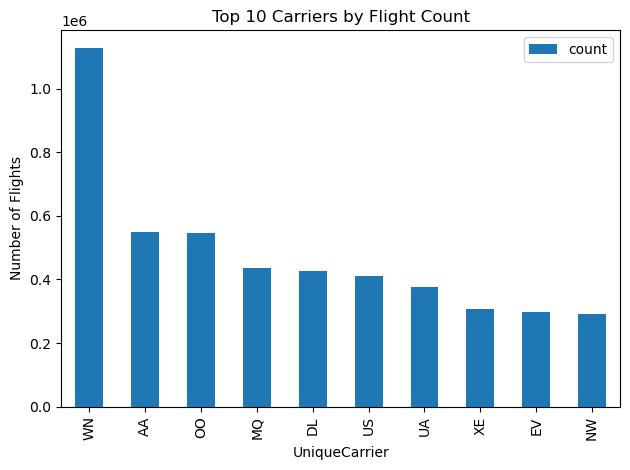

In [10]:
top_10_pd.plot(kind="bar", x="UniqueCarrier", y="count", title="Top 10 Carriers by Flight Count")
plt.ylabel("Number of Flights")
plt.tight_layout()
plt.show()

In [11]:
df.filter(col("CANCELLED") == 1.0).select("CANCELLATION_CODE").groupBy("CANCELLATION_CODE").count().show()

+-----------------+-----+
|CANCELLATION_CODE|count|
+-----------------+-----+
|                B|36651|
|                C|14799|
|                A|35568|
|                D|   20|
+-----------------+-----+




Cancellation reasons by code:
  CANCELLATION_CODE  count
0                 A  35568
1                 B  36651
2                 C  14799
3                 D     20


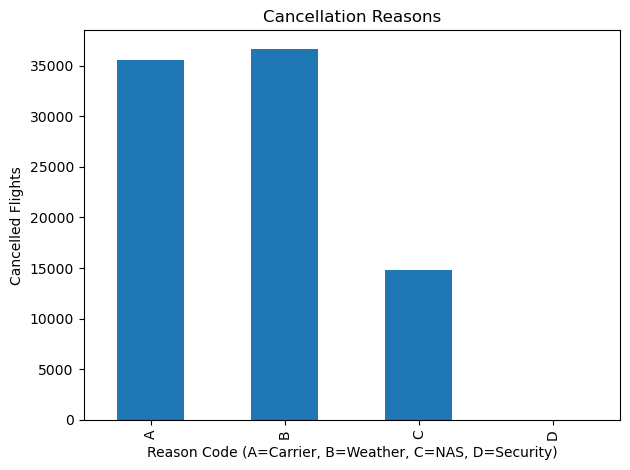

In [12]:
# Filter for cancelled flights
cancelled_df = df.filter(col("CANCELLED") == 1.0)

# Count cancellation reasons
cancel_reasons = cancelled_df.groupBy("CANCELLATION_CODE") \
    .count() \
    .orderBy("CANCELLATION_CODE")

cancel_reasons_pd = cancel_reasons.toPandas()

print("\nCancellation reasons by code:")
print(cancel_reasons_pd)

# Plot
cancel_reasons_pd.plot(kind="bar", x="CANCELLATION_CODE", y="count", legend=False, title="Cancellation Reasons")
plt.ylabel("Cancelled Flights")
plt.xlabel("Reason Code (A=Carrier, B=Weather, C=NAS, D=Security)")
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd

# Class distribution
class_dist = df.groupBy("CANCELLED").count().orderBy("CANCELLED")
class_dist_pd = class_dist.toPandas()

# Convert CANCELLED to numeric, clean and cast to int
class_dist_pd["CANCELLED"] = pd.to_numeric(class_dist_pd["CANCELLED"], errors="coerce").fillna(0).astype(int)

# Build count dictionary
class_counts = dict(zip(class_dist_pd["CANCELLED"], class_dist_pd["count"]))

# Extract counts
cancelled_count = class_counts.get(1, 0)
not_cancelled_count = class_counts.get(0, 0)

# Calculate imbalance ratio
imbalance_ratio = (not_cancelled_count / cancelled_count) if cancelled_count != 0 else float("inf")

# Output
print(f"\nCancelled flights: {cancelled_count}")
print(f"Not cancelled flights: {not_cancelled_count}")
print(f"Imbalance Ratio (Not Cancelled : Cancelled) = {imbalance_ratio:.2f}")



Cancelled flights: 87038
Not cancelled flights: 6326976
Imbalance Ratio (Not Cancelled : Cancelled) = 72.69


### Task 4 - Feature Engineering

In [14]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType

# Convert DEP_DELAY and DISTANCE to numeric types
df = df.withColumn("DEP_DELAY", col("DEP_DELAY").cast(DoubleType()))
df = df.withColumn("DISTANCE", col("DISTANCE").cast(DoubleType()))

In [15]:
# 1. Index categorical columns
categorical_cols = ["UniqueCarrier", "ORIGIN", "DEST", "DayOfWeek", "MonthName"]
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_Index", handleInvalid="keep") for col in categorical_cols]

# 2. One-hot encode the indexed columns
encoder = OneHotEncoder(inputCols=[f"{col}_Index" for col in categorical_cols],
                        outputCols=[f"{col}_Vec" for col in categorical_cols])

In [16]:
# 3. Assemble all features
feature_cols = ["DEP_DELAY", "DISTANCE"] + [f"{col}_Vec" for col in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [17]:
# 4. Build pipeline
pipeline = Pipeline(stages=indexers + [encoder, assembler])

# 5. Fit and transform the data
df = df.filter(
    col("DEP_DELAY").isNotNull() &
    col("DISTANCE").isNotNull() &
    col("UniqueCarrier").isNotNull() &
    col("ORIGIN").isNotNull() &
    col("DEST").isNotNull() &
    col("DayOfWeek").isNotNull() &
    col("MonthName").isNotNull()
)

pipeline_model = pipeline.fit(df)
df_prepared = pipeline_model.transform(df)

# Final DataFrame
df_final = df_prepared.select("features", "CANCELLED")
df_final.show(5, truncate=False)

+--------------------------------------------------------------+---------+
|features                                                      |CANCELLED|
+--------------------------------------------------------------+---------+
|(631,[0,1,9,44,332,616,627],[-2.0,199.0,1.0,1.0,1.0,1.0,1.0]) |0.0      |
|(631,[0,1,9,35,343,616,627],[-1.0,213.0,1.0,1.0,1.0,1.0,1.0]) |0.0      |
|(631,[0,1,9,35,340,616,627],[-1.0,199.0,1.0,1.0,1.0,1.0,1.0]) |0.0      |
|(631,[0,1,9,44,332,616,627],[9.0,199.0,1.0,1.0,1.0,1.0,1.0])  |0.0      |
|(631,[0,1,9,47,332,616,627],[-10.0,213.0,1.0,1.0,1.0,1.0,1.0])|0.0      |
+--------------------------------------------------------------+---------+
only showing top 5 rows



In [18]:
df.select("DEP_DELAY", "DISTANCE").printSchema()

root
 |-- DEP_DELAY: double (nullable = true)
 |-- DISTANCE: double (nullable = true)



### TASK 5 - Modeling

In [19]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col

In [20]:
df_final = df_final.withColumn("CANCELLED", col("CANCELLED").cast(DoubleType()))

assembler_input_cols = ["DEP_DELAY", "DISTANCE",
                        "UniqueCarrier_Vec", "ORIGIN_Vec",
                        "DEST_Vec", "DayOfWeek_Vec", "MonthName_Vec"]

# Remove rows with nulls in any feature used by VectorAssembler
df_final = df_final.withColumn("CANCELLED", col("CANCELLED").cast(DoubleType()))


# 1. Split the data
train_data, test_data = df_final.randomSplit([0.7, 0.3], seed=42)

# 2. Define models
lr = LogisticRegression(labelCol="CANCELLED", featuresCol="features")
dt = DecisionTreeClassifier(labelCol="CANCELLED", featuresCol="features")
rf = RandomForestClassifier(labelCol="CANCELLED", featuresCol="features")
gbt = GBTClassifier(labelCol="CANCELLED", featuresCol="features")

# 3. Define parameter grids (tuning one hyperparameter per model)
lr_grid = ParamGridBuilder().addGrid(lr.regParam, [0.01, 0.1]).build()
dt_grid = ParamGridBuilder().addGrid(dt.maxDepth, [3, 5, 10]).build()
rf_grid = ParamGridBuilder().addGrid(rf.numTrees, [10, 20]).build()
gbt_grid = ParamGridBuilder().addGrid(gbt.maxIter, [10, 20]).build()

# 4. Define evaluator for AUC and Accuracy
auc_evaluator = BinaryClassificationEvaluator(labelCol="CANCELLED", metricName="areaUnderROC")
acc_evaluator = MulticlassClassificationEvaluator(labelCol="CANCELLED", metricName="accuracy")

In [21]:
# 5. Set up CrossValidators
def get_cv(model, grid):
    return CrossValidator(estimator=model,
                          estimatorParamMaps=grid,
                          evaluator=auc_evaluator,
                          numFolds=3)

cv_lr = get_cv(lr, lr_grid)
cv_dt = get_cv(dt, dt_grid)
cv_rf = get_cv(rf, rf_grid)
cv_gbt = get_cv(gbt, gbt_grid)

In [22]:
print("Training models, this may take a few minutes...")

lr_model = cv_lr.fit(train_data)
print("Logistic regression model fitted")

Training models, this may take a few minutes...
Linear regression model fitted


In [23]:
dt_model = cv_dt.fit(train_data)
print("Decision tree model fitted")

Decision tree model fitted


In [24]:
rf_model = cv_rf.fit(train_data)
print("Random forest model fitted")

Random forest model fitted


In [25]:
gbt_model = cv_gbt.fit(train_data)
print("GBT model fitted")

GBT model fitted


In [26]:
# 7. Evaluate models on test data
models = [("Logistic Regression", lr_model),
          ("Decision Tree", dt_model),
          ("Random Forest", rf_model),
          ("Gradient Boosted Tree", gbt_model)]

for name, model in models:
    predictions = model.transform(test_data)
    auc = auc_evaluator.evaluate(predictions)
    acc = acc_evaluator.evaluate(predictions)
    print(f"\n{name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {auc:.4f}")


Logistic Regression
Accuracy: 0.9993
AUC: 0.7909

Decision Tree
Accuracy: 0.9993
AUC: 0.5713

Random Forest
Accuracy: 0.9993
AUC: 0.5000

Gradient Boosted Tree
Accuracy: 0.9993
AUC: 0.7540


### Task 6 - Feature Importances 

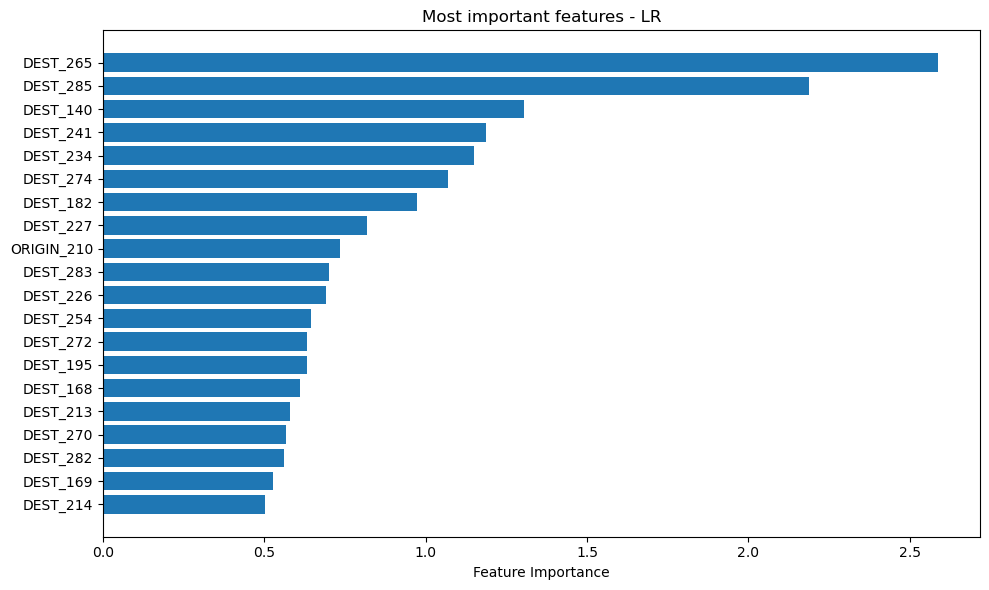

In [38]:
from pyspark.ml.feature import OneHotEncoderModel
import numpy as np

# Logistic Regression showed the best results
lr_best_model = lr_model.bestModel
# Use coefficients as importance indicators
importances = lr_best_model.coefficients.toArray()

# One-hot encoded features were expanded into multiple binary columns
encoder_model = [stage for stage in pipeline_model.stages if isinstance(stage, OneHotEncoderModel)][0]
encoded_sizes = encoder_model.categorySizes # number of categories for each feature

all_features = ["DEP_DELAY", "DISTANCE"]
for col_name, size in zip(categorical_cols, encoded_sizes):
    all_features += [f"{col_name}_{i}" for i in range(size)]

# Sort by importance, get top 20
top_n = 20
indices = np.argsort(importances)[-top_n:] # by default sort order is asc
top_features = [all_features[i] for i in indices]
top_importances = importances[indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances)
plt.xlabel("Feature Importance")
plt.title("Most important features - LR")
plt.tight_layout()
plt.show()

### Task 7

## Saving the best model

In [40]:
best_pipeline_model = Pipeline(stages=pipeline_model.stages + [lr_best_model])

# Fit the pipeline
final_model = best_pipeline_model.fit(df)

# Save the complete model
final_model.write().overwrite().save("../lab_data/saved_models/best_pipeline_model")

## Scoring data from 2010

In [63]:
# Apply the same preprocessing and cleaning steps

df_2010 = spark.read.option("header", "true").csv("../lab_data/2010.csv")

df_2010 = df_2010.filter(col("FL_DATE").startswith("2010"))
df_2010 = df_2010.withColumnRenamed("OP_CARRIER", "UniqueCarrier")
df_2010 = df_2010.withColumn("FL_DATE", to_date(col("FL_DATE"), "yyyy-MM-dd"))
df_2010 = df_2010.withColumn("DayOfWeek", dayofweek(col("FL_DATE")))
df_2010 = df_2010.withColumn("Month", month(col("FL_DATE")))
df_2010 = df_2010.withColumn("MonthName", month_name_expr)
df_2010 = df_2010.filter(
    ((col("CANCELLED") == 0.0) & col("DEP_TIME").isNotNull() & col("ARR_TIME").isNotNull()) |
    ((col("CANCELLED") == 1.0) & col("CANCELLATION_CODE").isNotNull())
)
df_2010 = df_2010.filter(col("DIVERTED") != 1)
df_2010 = df_2010.withColumn("DEP_DELAY", col("DEP_DELAY").cast(DoubleType()))
df_2010 = df_2010.withColumn("DISTANCE", col("DISTANCE").cast(DoubleType()))
df_2010 = df_2010.filter(
    col("DEP_DELAY").isNotNull() &
    col("DISTANCE").isNotNull() &
    col("UniqueCarrier").isNotNull() &
    col("ORIGIN").isNotNull() &
    col("DEST").isNotNull() &
    col("DayOfWeek").isNotNull() &
    col("MonthName").isNotNull()
)
df_2010 = df_2010.withColumn("CANCELLED", col("CANCELLED").cast(DoubleType()))
df_2010 = df_2010.filter(col("CANCELLED").isNotNull())

# Predict using the final model
predictions_2010 = final_model.transform(df_2010)

# Evaluate accuracy
auc_2010 = auc_evaluator.evaluate(predictions_2010)
acc_2010 = acc_evaluator.evaluate(predictions_2010)

print(f"2010 Accuracy: {acc_2010:.4f}")
print(f"2010 AUC: {auc_2010:.4f}")

2010 Accuracy: 0.9993
2010 AUC: 0.7740
